In [1]:
"""
Created on Wed May 29 21:29:54 2019

@author: John Kath
"""
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from pathlib import Path
from typing import List
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# data pre processing
file_name_to_colume_names = {
    'Accelerometer.csv': ['Systime', 'EventTime', 'ActivityID', 'X', 'Y', 'Z', 'Phone_orientation'],
    'Gyroscope.csv': ['Systime', 'EventTime', 'ActivityID', 'X', 'Y', 'Z', 'Phone_orientation'],
}

In [3]:
def read_file(user_id: str, user_session_id: str, file_name: str, colume_names: List[str]) -> DataFrame:
    """
    Read one of the csv files for a user
    :param user_id: user id
    :param user_session_id: user session id
    :param file_name: csv file name (key of file_name_to_colume_names)
    :param colume_names: a list of column names of the csv file (value of file_name_to_colume_names)
    :return: content of the csv file as pandas DataFrame
    """
    # read data from csv
    filename = user_id + '_session_' + user_session_id + '_' + file_name
    csv_data = pd.read_csv(filename, names=colume_names)
    return pd.DataFrame(data=csv_data)

In [4]:
# pick the user as well as activities and extract 3 out of 6 features
data_acc = read_file('984799', '16', 'Accelerometer.csv', file_name_to_colume_names['Accelerometer.csv'])
data_gyr = read_file('984799', '16', 'Gyroscope.csv', file_name_to_colume_names['Gyroscope.csv'])
# print(data_acc.dtypes)
# print(data_gyr.dtypes)

In [5]:
def plot_parametric_feature(x, y, z, label_name, color_name):
    # 3d parametric plot of feature
    plt.rcParams['legend.fontsize'] = 10
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(x, y, z, label=label_name, color=color_name)
    ax.legend()
    plt.show()

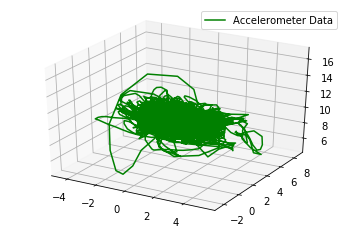

In [6]:
# visualize of the features you pick
x_val = data_acc['X']
y_val = data_acc['Y']
z_val = data_acc['Z']
plot_parametric_feature(x_val, y_val, z_val,'Accelerometer Data', 'g')

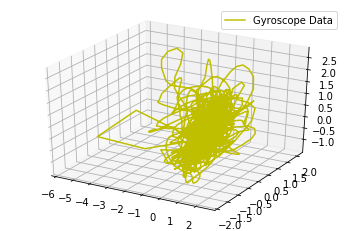

In [7]:
# visualize of the features you pick
x_val = data_gyr['X']
y_val = data_gyr['Y']
z_val = data_gyr['Z']
plot_parametric_feature(x_val, y_val, z_val,'Gyroscope Data', 'y')

In [8]:
def multiV_curvature(nbddata: DataFrame) -> float:  
    """
    Calculate multi V curvature
    :param nbddata: neighborhood of time t_i containing (t, x(t), y(t), z(t)), 
    where x(t), y(t), z(t) are the 3 out of the 6 features. 
    :return: multi V curvature
    """
    # neighborhood about time t_i
    t_val = nbddata['T']
    x_val = nbddata['X']
    y_val = nbddata['Y']
    z_val = nbddata['Z']
    # fit quadratic curve
    x_poly = np.polyfit(x_val, t_val, 2)
    y_poly = np.polyfit(y_val, t_val, 2)
    z_poly = np.polyfit(z_val, t_val, 2)
    # init vectors
    v0 = [x_poly[2], y_poly[2], z_poly[2]]
    v1 = [x_poly[1], y_poly[1], z_poly[1]]
    v2 = [x_poly[0], y_poly[0], z_poly[0]]
    # calc curvature
    v1_x_v2 = np.cross(v1, v2)
    norm_v1_x_v2 = np.linalg.norm(v1_x_v2)
    norm_v1 = np.linalg.norm(v1)
    curvature = (2 * norm_v1_x_v2) / (norm_v1 ** 3)
    return curvature

In [9]:
def multiV_torsion(nbddata: DataFrame) -> float:  
    """
    Calculate multi V torsion
    :param nbddata: neighborhood of time t_i containing (t, x(t), y(t), z(t)), 
    where x(t), y(t), z(t) are the 3 out of the 6 features. 
    :return: multi V torsion
    """
    # neighborhood about time t_i
    t_val = nbddata['T']
    x_val = nbddata['X']
    y_val = nbddata['Y']
    z_val = nbddata['Z']
    # fit cubic curve
    x_poly = np.polyfit(x_val, t_val, 3)
    y_poly = np.polyfit(y_val, t_val, 3)
    z_poly = np.polyfit(z_val, t_val, 3)
    # init vectors
    v0 = [x_poly[3], y_poly[3], z_poly[3]]
    v1 = [x_poly[2], y_poly[2], z_poly[2]]
    v2 = [x_poly[1], y_poly[1], z_poly[1]]
    v3 = [x_poly[0], y_poly[0], z_poly[0]]
    # calc torsion
    v1_x_v2 = np.cross(v1, v2)
    norm_v1_x_v2 = np.linalg.norm(v1_x_v2)
    det_v1_x_v2_dot_v3 = np.dot(v1_x_v2, v3)
    torsion = (3 * det_v1_x_v2_dot_v3) / (norm_v1_x_v2 ** 2)
    return torsion

In [10]:
def plot_scatter_feature(x, y, title_name, y_label_name, color_name):
    # scatter plot of feature
    plt.scatter(x, y, s=10, color=color_name, alpha=0.5)
    plt.title(title_name)
    plt.xlabel('Time')
    plt.ylabel(y_label_name)
    plt.show()

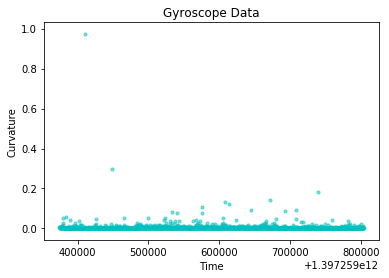

In [11]:
# calucate and plot curvature and torsion of the features you pick

data = data_gyr
time_i = []
curvature = []
step_size = 25
for i in range(0, len(data['Systime']) - 2*step_size, step_size):
    # center the data around the mean of the interval
    mean_time = sum(data['Systime'][i: i+step_size])/len(data['Systime'][i:i+step_size])
    t = data['Systime'][i: i+step_size] - mean_time
    time_i.append(mean_time)
    # set up interval around time t_i of size=step_size
    x = data['X'][i: i+step_size]
    y = data['Y'][i: i+step_size]
    z = data['Z'][i: i+step_size]
    curvature.append(multiV_curvature(pd.DataFrame(data={'T': t, 'X': x,'Y': y,'Z': z})))

plot_scatter_feature(time_i, curvature, 'Gyroscope Data', 'Curvature', 'c')

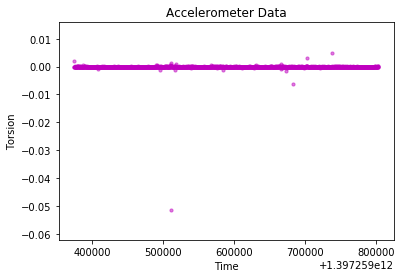

In [12]:
# calucate and plot curvature and torsion of the features you pick

data = data_acc
time_i = []
torsion = []
step_size = 25
for i in range(0, len(data['Systime']) - 2*step_size, step_size):
    # center the data around the mean of the interval
    mean_time = sum(data['Systime'][i: i+step_size])/len(data['Systime'][i:i+step_size])
    t = data['Systime'][i: i+step_size] - mean_time
    time_i.append(mean_time)
    # set up interval around time t_i of size=step_size
    x = data['X'][i: i+step_size]
    y = data['Y'][i: i+step_size]
    z = data['Z'][i: i+step_size]
    torsion.append(multiV_torsion(pd.DataFrame(data={'T': t, 'X': x,'Y': y,'Z': z})))

plot_scatter_feature(time_i, torsion, 'Accelerometer Data', 'Torsion', 'm')